In [2]:
import pandas as pd
import numpy as np
import os


ModuleNotFoundError: No module named 'pandas'

In [ ]:
pd.set_option('display.max_columns', None)

# Read datasets from the interim directory
X_train = pd.read_pickle("../../data/interim/X_train.pkl")
X_val = pd.read_pickle("../../data/interim/X_val.pkl")
X_test = pd.read_pickle("../../data/interim/X_test.pkl")
y_train = pd.read_pickle("../../data/interim/y_train.pkl")
y_val = pd.read_pickle("../../data/interim/y_val.pkl")
y_test = pd.read_pickle("../../data/interim/y_test.pkl")

In [ ]:
X_train

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
96879,-0.458843,-0.004343,-0.272226,0.032586,-0.057479,0.017799
96880,-0.881271,0.789259,-0.322166,0.031217,-0.012802,-0.002940
96881,-0.750800,0.547177,-0.330515,0.042022,0.011359,-0.011404
96882,-0.640295,0.394234,-0.315634,0.030857,0.012073,-0.015476
96883,-0.686538,0.550332,-0.359439,0.009593,0.003928,-0.010498
...,...,...,...,...,...,...
4138422,0.450731,0.535045,-0.324386,-0.031796,-0.059572,-0.027028
4138423,0.481948,0.536976,-0.334319,-0.016996,-0.046264,-0.028323
4138424,0.502064,0.539007,-0.333029,0.000452,-0.029247,-0.023712
4138425,0.498980,0.536931,-0.329682,0.008017,-0.019459,-0.027067


In [ ]:
y_train

96879      STD
96880      STD
96881      STD
96882      STD
96883      STD
          ... 
4138422    STD
4138423    STD
4138424    STD
4138425    STD
4138426    STD
Name: label, Length: 2781516, dtype: object

In [1]:
fall_labels = ['BSC', 'FKL', 'SDL', 'FOL']
y_train = y_train_series.replace(fall_labels, 'FALL')

NameError: name 'y_train_series' is not defined

### Segment into Windows

In [18]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

def create_windows(X, y, window_size=50, step_size=40):
    X_windows, y_windows = [], []
    
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data = X[start:end]
        window_labels = y[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X_windows.append(window_data)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)

In [19]:
X_train_windows, y_train_windows = create_windows(X_train, y_train)
X_val_windows, y_val_windows = create_windows(X_val, y_val)
X_test_windows, y_test_windows = create_windows(X_test, y_test)

### Encode Label

In [20]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform on the windowed training labels
y_train_windows_encoded = le.fit_transform(y_train_windows)

# Transform the validation and test windowed labels based on the same encoding
y_val_windows_encoded = le.transform(y_val_windows)
y_test_windows_encoded = le.transform(y_test_windows)

In [24]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv1D, ReLU, MaxPooling1D, GlobalAveragePooling1D,
    Dense, Dropout, BatchNormalization, concatenate
)
from tensorflow.keras.optimizers import Adam


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D,GlobalAveragePooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Define the input shape (e.g., 25 time steps, 6 channels)
input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])
num_classes = len(set(y_train_windows_encoded))  # Should be 15 based on your labels

model = Sequential([
    # First convolutional block
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    # Second convolutional block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    # Apply max pooling to reduce sequence length and capture dominant features
    MaxPooling1D(pool_size=2),
    # Third convolutional block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    # Global average pooling to flatten the tensor for the dense layer
    GlobalAveragePooling1D(),
    # Fully connected (dense) layer with dropout
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Output layer: softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])

# Compile the model with a common optimizer and loss function for classification
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'dual_encoder_with_pair_ssl', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "dual_encoder_with_pair_ssl"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_33 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_11     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_12     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(X_train_windows, y_train_windows_encoded,
                    validation_data=(X_val_windows, y_val_windows_encoded),
                    epochs=25, batch_size=32)

Epoch 1/25


OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.7914
Test Accuracy: 0.8302
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


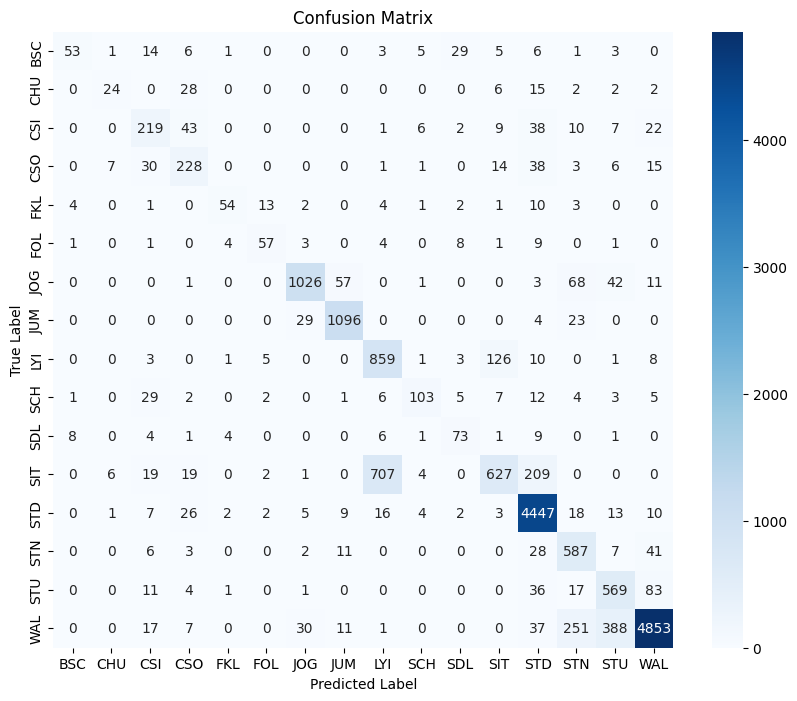

Classification Report:
               precision    recall  f1-score   support

         BSC       0.79      0.42      0.55       127
         CHU       0.62      0.30      0.41        79
         CSI       0.61      0.61      0.61       357
         CSO       0.62      0.66      0.64       343
         FKL       0.81      0.57      0.67        95
         FOL       0.70      0.64      0.67        89
         JOG       0.93      0.85      0.89      1209
         JUM       0.92      0.95      0.94      1152
         LYI       0.53      0.84      0.65      1017
         SCH       0.81      0.57      0.67       180
         SDL       0.59      0.68      0.63       108
         SIT       0.78      0.39      0.52      1594
         STD       0.91      0.97      0.94      4565
         STN       0.59      0.86      0.70       685
         STU       0.55      0.79      0.64       722
         WAL       0.96      0.87      0.91      5595

    accuracy                           0.83     17917
  

In [11]:
label_classes = [
    'BSC', 'CHU', 'CSI', 'CSO', 'FKL', 'FOL', 
    'JOG', 'JUM', 'LYI', 'SCH', 'SDL', 'SIT', 
    'STD', 'STN', 'STU', 'WAL'
]

metrics = evaluate_model(model, X_test_windows, y_test_windows_encoded, label_classes=label_classes)


### 10-Fold Cross Validation

In [12]:
from sklearn.model_selection import GroupKFold

In [13]:
# Read datasets from the interim directory
df_filtered = pd.read_pickle("../../data/interim/df_filtered.pkl")

In [14]:
from tensorflow.keras import Input

def build_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, 3, activation='relu'),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
sensor_cols = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']
groups     = df_filtered['subject_id'].values
gkf        = GroupKFold(n_splits=10)

val_losses     = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(
        gkf.split(df_filtered, df_filtered['label'], groups=groups)):

    # ----- 1) Select raw fold data -----
    df_tr = df_filtered.iloc[train_idx]
    df_va = df_filtered.iloc[val_idx]

    X_tr_raw = df_tr[sensor_cols].values
    y_tr_raw = df_tr['label'].values
    X_va_raw = df_va[sensor_cols].values
    y_va_raw = df_va['label'].values

    # ----- 2) Window -----
    X_train_windows, y_train_windows = create_windows(X_tr_raw, y_tr_raw,
                                                      window_size=50,
                                                      step_size=25)
    X_val_windows,   y_val_windows   = create_windows(X_va_raw, y_va_raw,
                                                      window_size=50,
                                                      step_size=25)

    # ----- 3) Encode labels -----
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_windows)
    y_val_encoded   = le.transform(y_val_windows)

    # ----- 4) Build model -----
    input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])  # (50,6)
    num_classes = len(le.classes_)

    model = build_model(input_shape, num_classes)
    

    # ----- 5) Train -----
    history = model.fit(
        X_train_windows, y_train_encoded,
        validation_data=(X_val_windows, y_val_encoded),
        epochs=25, batch_size=32, verbose=0
    )

    # ----- 6) Collect metrics -----
    val_loss = history.history['val_loss'][-1]
    val_acc  = history.history['val_accuracy'][-1]
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Fold {fold+1} — val_loss: {val_loss:.4f}, val_acc: {val_acc:.4%}")

# ----- 7) Aggregate across folds -----
mean_loss = np.mean(val_losses)
std_loss  = np.std(val_losses)
mean_acc  = np.mean(val_accuracies)
std_acc   = np.std(val_accuracies)

print("\n=== Cross‐Validation Results ===")
print(f"Val Loss: {mean_loss:.4f} ± {std_loss:.4f}")
print(f"Val Acc:  {mean_acc:.4%} ± {std_acc:.4%}")


Fold 1 — val_loss: 0.4786, val_acc: 87.6106%
Fold 2 — val_loss: 0.7331, val_acc: 81.8111%
Fold 3 — val_loss: 0.7276, val_acc: 81.1194%
Fold 4 — val_loss: 1.0529, val_acc: 79.5446%
Fold 5 — val_loss: 0.3446, val_acc: 90.5028%
Fold 6 — val_loss: 0.4814, val_acc: 86.8272%
Fold 7 — val_loss: 0.8414, val_acc: 83.3223%


KeyboardInterrupt: 